# LINFA Tutorial
This LINFA tutorial will guide through the definition of each of the quantities and functions of LINFA by applying LINFA to a practical problem set.
<br>

* **What is LINFA?**
<br> 
    LINFA is a library for variational inference with normalizing flow and adaptive annealing. LINFA accommodates computationally expensive models and difficult-to-sample posterior distributions with dependent parameters.

* **Why use LINFA?**
<br>
    Designed as a general inference engine, LINFA allows the user to define custom input transformations, computational models, surrogates, and likelihood functions which will be discussed throughout the tutorial.

### Tutorial outline
In this tutorial we will:

1. Define a physics-based model for a simple ballistic application.

2. Perform the following inference tasks:

    * Variational inference with the original model.

    * Variational inference with a neural network surrogate.

After going through this tutorial, users should be able to define and integrate their model with LINFA, and use its various features to perform inference tasks.

In addition, we emphasize two special features available through LINFA:

* Adaptively trained surrogate models (NoFAS module).

* Adaptive annealing schedulers (AdaAnn module).

They are especially useful when using computationally expensive physics-based models and difficult-to-sample posterior distributions. 

### Additional Resources

#### Background theory and examples for LINFA

* Y. Wang, F. Liu and D.E. Schiavazzi, Variational Inference with NoFAS: Normalizing Flow with Adaptive Surrogate for Computationally Expensive Models: https://www.sciencedirect.com/science/article/abs/pii/S0021999122005162

* E.R. Cobian, J.D. Hauenstein, F. Liu and D.E. Schiavazzi, AdaAnn: Adaptive Annealing Scheduler for Probability Density Approximation:
https://www.dl.begellhouse.com/journals/52034eb04b657aea,796f39cb1acf1296,6f85fe1149ff41d9.html?sgstd=1


#### More about LINFA library: 

* LINFA library [documentation](https://linfa-vi.readthedocs.io/en/latest/index.html).

* LINFA GitHub [repository](https://github.com/desResLab/LINFA)

In [3]:
## Import libraries ##
import os
from linfa.run_experiment import experiment
from linfa.transform import Transformation
from linfa.nofas import Surrogate
import torch
import random
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import cv2

### Problem definition
* Our physics-based model **phys** consists of a simple ballistic model. We would like to compute the quantities: 
    * $x_{1}$: *final location (m)*
    * $x_{2}$: *total time of the entire trajectory motion (s)*
    
    from the inputs:
    * $z_{1}$: *starting position (m)*
    * $z_{2}$: *initial velocity (m/s)*
<br>

The model is described by the following equations
$$
x_{1} = z_{1} + \frac{z_{2}^{2}\,\sin(2\,60)}{g},\,\,
x_{2} = \frac{2\,z_{2}\,\sin(60)}{g}.
$$

This corresponds to the situation where a target location is reached from an object launched at an horizontal angle of 60 degrees. 

#### Model identifiability

This model is identifiable.

#### Implementation as a Python class

* We now create a new **Phys** model class, having three member functions:
    * `__init__`: A constructor.
    * `genDataFile`: A member function to create synthetic observations.
    * `solve_t`: A function to perform forward model evaluations.

*Please refer to the comments below for additional implementation details.* 

In [4]:
#### Implementation of the traditional trajectory motion physics problem ####
class Phys:
    
    ### Define constructor function for Phys class ###
    def __init__(self):
        ## Define input parameters (True value)  
        # input[] = [starting_position, initial_velocity, angle] = [1(m), 5(m/s)]
        self.defParam = torch.Tensor([[1.0, 5.0]])
        
        self.gConst = 9.81   # gravitational constant
        self.stdRatio = 0.05 # standard deviation ratio
        self.data = None     # data set of model sample

    ### Define data file generator function ###
    # dataSize (int): size of sample (data)
    # dataFileName (String): name of the sample data file
    # store (Boolean): True if user wish to store the generated data file; False otherwise.
    def genDataFile(self, dataSize = 50, dataFileName="data_phys_2d.txt", store=True):
        def_out = self.solve_t(self.defParam)[0]
        self.data = def_out + self.stdRatio * torch.abs(def_out) * torch.normal(0, 1, size=(dataSize, 2))
        self.data = self.data.t().detach().numpy()
        if store: np.savetxt(dataFileName, self.data)
        return self.data

    ### Define data file generator function ###
    # params (Tensor): input parameters storing starting position, initial velocity, and angle in corresponding order.
    def solve_t(self, params):
        z1, z2 = torch.chunk(params, chunks=2, dim=1) # input parameters
        z3 = torch.Tensor([[60.0]])
        z3 = z3 * (np.pi / 180)                           # convert unit from degree to radians

        ## Output value calculation
        # ouput[] = [final_location, total_time]
        x = torch.cat(( z1 + ((z2 * z2 * torch.sin(2.0 * z3)) / self.gConst),             # x2: finalLocation 
            (2.0 * z2 * torch.sin(z3)) / self.gConst), 1)                                 # x3: totalTime
        return x

In [5]:
## Generate phys sample file ##

# Define model
model = Phys()

# Generate Data
physData = model.genDataFile()

Now that we have our model set up, we go on to our second step, i.e., *inference with the full model.*

### Variational inference with full model

#### Definition of hyperparameters
The first step is to define all options and hyperparameters for the inference task. Additional detail for each hyperparameter can be found in the [documentation](https://linfa-vi.readthedocs.io/en/latest/content/linfa_options.html) or in the definition of the [experiment](https://github.com/desResLab/LINFA/blob/master/linfa/run_experiment.py) class.

In [6]:
# Experiment Setting
exp = experiment()
exp.flow_type        = 'maf'        # str: Type of flow
exp.n_blocks         = 5            # int: Number of layers                            
exp.hidden_size      = 100          # int: Hidden layer size for MADE in each layer  
exp.n_hidden         = 1            # int: Number of hidden layers in each MADE      
exp.activation_fn    = 'relu'       # str: Actication function used                  
exp.input_order      = 'sequential' # str: Input order for create_mask           
exp.batch_norm_order = True         # boolean: Order to decide if batch_norm is used    
exp.save_interval    = 5000         # int: How often to sample from normalizing flow

exp.input_size    = 2               # int: Dimensionality of input                   
exp.batch_size    = 200             # int: Number of samples generated             
exp.true_data_num = 2               # double: number of true model evaluated      
exp.n_iter        = 25001           # int: Number of iterations                      
exp.lr            = 0.01            # float: Learning rate                              
exp.lr_decay      = 0.9999          # float: Learning rate decay                
exp.log_interval  = 100             # int: How often to show loss stat   

exp.run_nofas          = False      # boolean: to run experiment with nofas
exp.annealing          = False      # boolean: to run experiment with annealing
exp.calibrate_interval = 1000       # int: How often to update surrogate model     
exp.budget             = 260        # int: Total number of true model evaluation

exp.surr_pre_it  = 30000            # int: Number of pre-training iterations for surrogate model
exp.surr_upd_it  = 6000             # int: Number of iterations for the surrogate model update
exp.surr_folder  = "./"
exp.use_new_surr = True             # boolean: to run experiment with nofas

exp.results_file = 'results.txt'      # str: result text file name
exp.log_file     = 'log.txt'          # str: log text file name
exp.samples_file = 'samples.txt'      # str: sample text file name
exp.seed         = random.randint(0, 10 ** 9)  # int: Random seed used
exp.n_sample     = 5000               # int: Total number of iterations
exp.no_cuda      = True               # boolean: to run experiment with NO cuda

exp.optimizer    = 'RMSprop'          # str: Type of optimizer
exp.lr_scheduler = 'ExponentialLR'    # str: Type of scheduler

exp.device = torch.device('cuda:0' if torch.cuda.is_available() and not exp.no_cuda else 'cpu')

#### Define the transformation 
Now we define the trasformation of parameters and initialize the `exp.transform` variable

In [7]:
# Define transformation based on normalization rate
trsf_info = [['identity',0.0,0.0,0.0,0.0],
             ['identity',0.0,0.0,0.0,0.0]]
trsf = Transformation(trsf_info)        
exp.transform = trsf

#### Model and surrogate definition
We create an instance of the **Phys** model and assign `None` to the surrogate.

In [8]:
# Define model
model = Phys()
exp.model = model

# Get data
model.data = np.loadtxt('./data_phys_2d.txt')

# Run experiment without surrogate
exp.surrogate = None

#### Log-likelihood definiton

In [12]:
## Define log density
# x: original, untransformed inputs
# model: our model
# transform: our transformation 
def log_density(x, model, surrogate, transform):
    # x contains the original, untransformed inputs
    np.savetxt(exp.output_dir + '/' + exp.name + '_x', x.detach().numpy(), newline="\n")
    # Compute transformation log Jacobian
    adjust = transform.compute_log_jacob_func(x)

    batch_size = x.size(0)
    # Get the absolute values of the standard deviations
    stds = torch.abs(model.solve_t(model.defParam)) * model.stdRatio
    Data = torch.tensor(model.data).to(exp.device)
    
    # Check for surrogate
    if surrogate:
        modelOut = exp.surrogate.forward(x)
    else:
        modelOut = model.solve_t(transform.forward(x))

    # Eval LL
    ll1 = -0.5 * np.prod(model.data.shape) * np.log(2.0 * np.pi)
    ll2 = (-0.5 * model.data.shape[1] * torch.log(torch.prod(stds))).item()
    ll3 = 0.0
    
    for i in range(2):
        ll3 += - 0.5 * torch.sum(((modelOut[:, i].unsqueeze(1) - Data[i, :].unsqueeze(0)) / stds[0, i]) ** 2, dim=1)

    negLL = -(ll1 + ll2 + ll3)
    
    # Return LL
    return -negLL.reshape(x.size(0), 1) + adjust

#### Launch inference task

In [13]:
## Run 
print('')
print('--- Temporary TEST: Physics Example - without NOFAS')
print('')

# Experiment Setting
exp.name = "phys_full_2d"        # str: Name of experiment
exp.output_dir   = './' + exp.name    # str: output directory location

# Assign logdensity
exp.model_logdensity = lambda x: log_density(x, model, exp.surrogate, trsf)

# Run VI
exp.run()


--- Temporary TEST: Physics Example - without NOFAS


--- Running on device: cpu

VI NF (t=1.000): it:     100 | loss: 5.415e+03
VI NF (t=1.000): it:     200 | loss: 2.116e+03
VI NF (t=1.000): it:     300 | loss: 1.017e+03
VI NF (t=1.000): it:     400 | loss: 5.071e+02
VI NF (t=1.000): it:     500 | loss: 2.040e+02
VI NF (t=1.000): it:     600 | loss: 7.246e+01
VI NF (t=1.000): it:     700 | loss: 3.559e+01
VI NF (t=1.000): it:     800 | loss: 3.411e+01
VI NF (t=1.000): it:     900 | loss: 3.163e+01
VI NF (t=1.000): it:    1000 | loss: 3.339e+01
VI NF (t=1.000): it:    1100 | loss: 3.128e+01
VI NF (t=1.000): it:    1200 | loss: 3.222e+01
VI NF (t=1.000): it:    1300 | loss: 3.135e+01
VI NF (t=1.000): it:    1400 | loss: 3.143e+01
VI NF (t=1.000): it:    1500 | loss: 3.133e+01
VI NF (t=1.000): it:    1600 | loss: 3.121e+01
VI NF (t=1.000): it:    1700 | loss: 3.128e+01
VI NF (t=1.000): it:    1800 | loss: 3.112e+01
VI NF (t=1.000): it:    1900 | loss: 3.153e+01
VI NF (t=1.000): it:    

Notice that the model evaluation has been successfully completed by checking at the newly created **phys_nofasFree_2d** folder in our current directory.

Note also that LINFA supports a post processing script to plot the results, including 

* Loss profile.

* Sample-based characterization of the posterior distribution.

* Sample-based characterization of the posterior preditive distribution with observations.

In [14]:
import linfa
! python3 -m linfa.plot_res -n phys_full_2d -i 25000 -f "./" -p 'png' -d

Plotting log...
Plotting posterior samples...
Plotting posterior predictive samples...


### Variational inference with neural network surrogate model

LINFA enables the construction of an adaptively trained surrogate model which resolves such concerns regarding the computational cost of inference. 

By utilizing the surrogate model, model evaluations are replaced by interrogating the surrogate at a significantly cheaper computational cost.

#### Model and surrogate definition
We create an instance of the **Phys** model and create an instance of a surrogate using our built-in Surrogate constructor.

In [18]:
# Experiment Setting
exp = experiment()

exp.name             = "phys_surr_2d"      # str: Name of experiment
exp.output_dir       = './' + exp.name    # str: output directory location

exp.flow_type        = 'maf'        # str: Type of flow
exp.n_blocks         = 5            # int: Number of layers                            
exp.hidden_size      = 100          # int: Hidden layer size for MADE in each layer  
exp.n_hidden         = 1            # int: Number of hidden layers in each MADE      
exp.activation_fn    = 'relu'       # str: Actication function used                  
exp.input_order      = 'sequential' # str: Input order for create_mask           
exp.batch_norm_order = True         # boolean: Order to decide if batch_norm is used    
exp.save_interval    = 5000         # int: How often to sample from normalizing flow

exp.input_size    = 2               # int: Dimensionality of input                   
exp.batch_size    = 200             # int: Number of samples generated             
exp.true_data_num = 2               # double: number of true model evaluated      
exp.n_iter        = 25001           # int: Number of iterations                      
exp.lr            = 0.01            # float: Learning rate                              
exp.lr_decay      = 0.9999          # float: Learning rate decay                
exp.log_interval  = 100             # int: How often to show loss stat   

exp.run_nofas          = True       # boolean: to run experiment with nofas
exp.annealing          = False      # boolean: to run experiment with annealing
exp.calibrate_interval = 1000       # int: How often to update surrogate model     
exp.budget             = 5000       # int: Total number of true model evaluation

exp.surr_pre_it  = 30000            # int: Number of pre-training iterations for surrogate model
exp.surr_upd_it  = 6000             # int: Number of iterations for the surrogate model update
exp.surr_folder  = "./"
exp.use_new_surr = True             # boolean: to run experiment with nofas

exp.results_file = 'results.txt'      # str: result text file name
exp.log_file     = 'log.txt'          # str: log text file name
exp.samples_file = 'samples.txt'      # str: sample text file name
exp.seed         = random.randint(0, 10 ** 9)  # int: Random seed used
exp.n_sample     = 5000               # int: Total number of iterations
exp.no_cuda      = True               # boolean: to run experiment with NO cuda

exp.optimizer    = 'RMSprop'          # str: Type of optimizer
exp.lr_scheduler = 'ExponentialLR'    # str: Type of scheduler

exp.device = torch.device('cuda:0' if torch.cuda.is_available() and not exp.no_cuda else 'cpu')

# Define transformation based on normalization rate
trsf_info = [['identity',0.0,0.0,0.0,0.0],
             ['identity',0.0,0.0,0.0,0.0]]
trsf = Transformation(trsf_info)        
exp.transform = trsf


In [19]:
# Define model
model = Phys()
exp.model = model

# Get data
model.data = np.loadtxt('./data_phys_2d.txt')

# Define surrogate
exp.surrogate = Surrogate(exp.name, lambda x: model.solve_t(trsf.forward(x)), exp.input_size, 2, dnn_arch = [128, 64],
                          model_folder=exp.surr_folder, limits=torch.Tensor([[0, 2], [0, 10]]), 
                          memory_len=20, device=exp.device)
surr_filename = exp.surr_folder + exp.name

if exp.use_new_surr or (not os.path.isfile(surr_filename + ".sur")) or (not os.path.isfile(surr_filename + ".npz")):
    print("Warning: Surrogate model files: {0}.npz and {0}.npz could not be found. ".format(surr_filename))
    # 4 samples for each dimension
    exp.surrogate.gen_grid(gridnum=4) 
    exp.surrogate.pre_train(exp.surr_pre_it, 0.01, 0.9999, 500, store=True)
    
# Load the surrogate
exp.surrogate.surrogate_load()

Suggestion: Use Surrogate.gen_grid(input_limits=None, grid_num=5, store=True)

--- Pre-training surrogate model

SUR: PRE: it:       0 | loss: 1.680e+00
SUR: PRE: it:     500 | loss: 1.963e-02
SUR: PRE: it:    1000 | loss: 2.407e-02
SUR: PRE: it:    1500 | loss: 1.049e-02
SUR: PRE: it:    2000 | loss: 7.563e-03
SUR: PRE: it:    2500 | loss: 6.208e-03
SUR: PRE: it:    3000 | loss: 7.349e-03
SUR: PRE: it:    3500 | loss: 6.506e-03
SUR: PRE: it:    4000 | loss: 4.128e-03
SUR: PRE: it:    4500 | loss: 3.097e-03
SUR: PRE: it:    5000 | loss: 2.454e-03
SUR: PRE: it:    5500 | loss: 1.429e-03
SUR: PRE: it:    6000 | loss: 1.274e-03
SUR: PRE: it:    6500 | loss: 1.036e-03
SUR: PRE: it:    7000 | loss: 5.934e-04
SUR: PRE: it:    7500 | loss: 3.743e-04
SUR: PRE: it:    8000 | loss: 7.861e-04
SUR: PRE: it:    8500 | loss: 1.483e-03
SUR: PRE: it:    9000 | loss: 7.878e-04
SUR: PRE: it:    9500 | loss: 6.469e-04
SUR: PRE: it:   10000 | loss: 8.619e-04
SUR: PRE: it:   10500 | loss: 4.657e-04
SUR: PR

#### Launch inference task

In [20]:
## Run 
print('')
print('--- Temporary TEST: Physics Example - with NOFAS')
print('')

# Assign logdensity
exp.model_logdensity = lambda x: log_density(x, model, exp.surrogate, trsf)

# Run VI
exp.run()


--- Temporary TEST: Physics Example - with NOFAS


--- Running on device: cpu

VI NF (t=1.000): it:     100 | loss: 6.041e+03
VI NF (t=1.000): it:     200 | loss: 2.607e+03
VI NF (t=1.000): it:     300 | loss: 6.170e+02
VI NF (t=1.000): it:     400 | loss: 5.255e+02
VI NF (t=1.000): it:     500 | loss: 5.003e+02
VI NF (t=1.000): it:     600 | loss: 4.802e+02
VI NF (t=1.000): it:     700 | loss: 4.736e+02
VI NF (t=1.000): it:     800 | loss: 4.743e+02
VI NF (t=1.000): it:     900 | loss: 4.734e+02

--- Updating surrogate model

Std before inflation -> Std after inflation
6.111e-03 -> 1.058e-01
5.825e-03 -> 8.819e-02

SUR: UPD: it:       0 | loss: 1.071e-02
SUR: UPD: it:     500 | loss: 1.240e-03
SUR: UPD: it:    1000 | loss: 8.859e-04
SUR: UPD: it:    1500 | loss: 2.054e-04
SUR: UPD: it:    2000 | loss: 4.302e-05
SUR: UPD: it:    2500 | loss: 4.385e-05
SUR: UPD: it:    3000 | loss: 9.119e-06
SUR: UPD: it:    3500 | loss: 5.706e-06
SUR: UPD: it:    4000 | loss: 1.156e-06
SUR: UPD: it:  

Check model evaluation completion at the newly created **phys_surr_2d** folder in our current directory.

In [21]:
import linfa
! python3 -m linfa.plot_res -n phys_surr_2d -i 25000 -f "./" -p 'png' -d

Plotting log...
Plotting posterior samples...
Plotting posterior predictive samples...


#### Results
The plots below are results of variational inference with the full model and the variational inference with the neural network surrogate model combined. 

##### Loss profile plots

The first set of plots are log-loss plots, results of the log-loss as iteration increases.

Text(0.5, 1.0, 'Phys. without Surrogate')

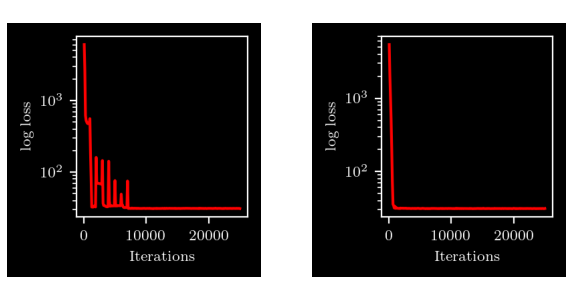

In [22]:
## log-loss plots

# create figure
fig = plt.figure(figsize=(10, 7))
plt.style.use('dark_background')

# setting row and column variables
rows = 1 
columns = 2

# reading images
logLoss_phys = cv2.imread('./phys_surr_2d/log_plot.png')
logLoss_physFree = cv2.imread('./phys_full_2d/log_plot.png')

# Adds a subplot at the 1st position
fig.add_subplot(rows, columns, 1)

# Add subplots corresponding to Phys with Surrogate
plt.imshow(logLoss_phys)
plt.axis('off')
plt.title("Phys. with Surrogate")

# Add subplots corresponding to Phys without Surrogate
fig.add_subplot(rows, columns, 2)
# showing image
plt.imshow(logLoss_physFree)
plt.axis('off')
plt.title("Phys. without Surrogate")

##### Plots of predictive posterior distribution and observations

The second set of plots are ouput estimation plots where the axis correspond to the range of the ouput estimation for each variable where the expected exact output values are: <br>

$x_1$: *3.2070* <br>
$x_2$: *0.8828* <br>

Within the output estimation plots, the samples are displayed as blue dots and the estimated region forms a cluster. We expect to observe the samples (blue dots) being distributed within the estimated region (red cluster). 

Text(0.5, 1.0, 'Phys. without Surrogate')

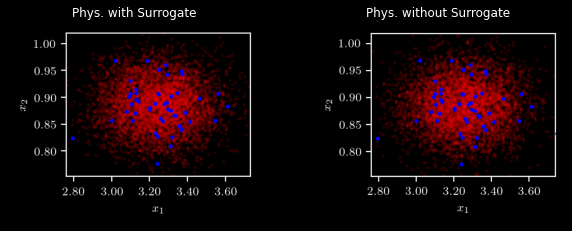

In [23]:
## output plots

# create figure
fig = plt.figure(figsize=(10, 7))
plt.style.use('dark_background')

# setting row and column variables
rows = 1
columns = 2

# reading images
phys1 = cv2.imread('./phys_surr_2d/data_plot_phys_surr_2d_25000_0_1.png')
physFree1 = cv2.imread('./phys_full_2d/data_plot_phys_full_2d_25000_0_1.png')

# Add subplots corresponding to Phys with Surrogates
fig.add_subplot(rows, columns, 1)
plt.imshow(phys1)
plt.axis('off')
plt.title("Phys. with Surrogate")

# Add subplots corresponding to Phys without Surrogate
fig.add_subplot(rows, columns, 2)
plt.imshow(physFree1)
plt.axis('off')
plt.title("Phys. without Surrogate")


##### Plots of posterior density

The third set of plots are parameter estimation plots where the axis correspond to the range of the parameter estimation for each variable where the expected exact input parameter values are expected to be:

$z_1$: *1* <br>
$z_2$: *5* <br>

Text(0.5, 1.0, 'Phys. without Surrogate')

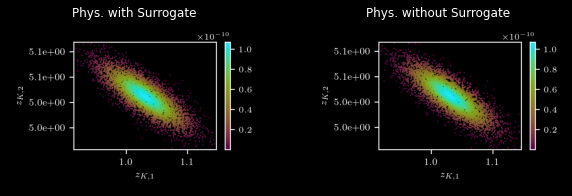

In [24]:
## parameter estimation plots

# create figure
fig = plt.figure(figsize=(10, 7))
plt.style.use('dark_background')

# setting row and column variables
rows = 1
columns = 2

# reading images
phys1 = cv2.imread('./phys_surr_2d/params_plot_phys_surr_2d_25000_0_1.png')
physFree1 = cv2.imread('./phys_full_2d/params_plot_phys_full_2d_25000_0_1.png')

# Add subplots corresponding to Phys with Surrogates
fig.add_subplot(rows, columns, 1)
plt.imshow(phys1)
plt.axis('off')
plt.title("Phys. with Surrogate")

# Add subplots corresponding to Phys without Surrogate
fig.add_subplot(rows, columns, 2)
plt.imshow(physFree1)
plt.axis('off')
plt.title("Phys. without Surrogate")

Based on the generated plots, we've observed the physical benefits of the Surrogate model and the functionality of the Phys. model estimation utilizing LINFA. <br>

Moreover, LINFA supports various model types. 

For more information, please refer to our [paper](https://arxiv.org/abs/2307.04675) *Appendix B. Detailed numerical benchmarks* where a few more examples are discussed.